In [16]:
import sys
import os
import matplotlib.pyplot as plt

# TFC training

In [17]:
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/model')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/trainer')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/dataloader')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/SleepEEG_Configs')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/HAR_Configs')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/FOG_Configs')


In [18]:
import torch
from torch import nn
from model import TFC, target_classifier
from dataloader import data_generator
from trainer import model_pretrain


In [19]:
torch.backends.mps.is_available()

True

### define configs

In [20]:
# from SleepEEG_Configs import Config as Configs

# SEED = 42
# arch = 'sleep_EEG'
# save_model_path = 'experiment_logs/pretrainmodel/'
# sourcedata_path = '../datasets/SleepEEG/'
# targetdata_path = '../datasets/Epilepsy/'

In [23]:
from HAR_Configs import Config as Configs

SEED = 42
arch = 'HAR'
save_model_path = 'experiment_logs/pretrainmodel/'
sourcedata_path = '../datasets/HAR/'
targetdata_path = '../datasets/Gesture/'

In [24]:
training_mode = 'pre_train'
subset = True


device = torch.device("mps")
configs = Configs()

In [25]:
configs.input_channels

1

### create TFC model and finetuning classifier

In [26]:
TFC_model = TFC(configs).to(device)

### create optimizers

In [27]:
model_optimizer = torch.optim.Adam(TFC_model.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)

criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, 'min')

### load datasets

In [28]:
train_dl, _, _ = data_generator(sourcedata_path, targetdata_path, configs, training_mode, subset=subset)

Using subset for debugging, the datasize is: 1280
Using subset for debugging, the datasize is: 320


In [29]:
data, labels, aug1, data_f, aug1_f = next(iter(train_dl))

In [30]:
data.shape

torch.Size([128, 1, 206])

In [31]:
# idx = 10
# plt.plot(aug1[idx,0,:].numpy())
# plt.plot(data[idx,0,:].numpy())
# plt.show()

# plt.plot(aug1_f[0,0,:].numpy())
# plt.plot(data_f[idx,0,:].numpy())
# plt.ylim(0,20)

### finetune and test loop

In [32]:
### Pretraining on source dataset

for epoch in range(1, configs.num_epoch + 1):

    train_loss = model_pretrain(TFC_model, model_optimizer, criterion, train_dl, configs, device, training_mode)


os.makedirs(save_model_path, exist_ok=True)
chkpoint = {'model_state_dict': TFC_model.state_dict()}
torch.save(chkpoint, os.path.join(save_model_path, f'{arch}_ckp_last.pt'))

Pretraining: overall loss:8.87309741973877, l_t: 6.417147159576416, l_f:6.0149359703063965, l_c:6.386680603027344
Pretraining: overall loss:8.619485855102539, l_t: 6.080162525177002, l_f:5.879101753234863, l_c:6.227632522583008
Pretraining: overall loss:8.460010528564453, l_t: 5.9906392097473145, l_f:5.8426103591918945, l_c:6.093360424041748
Pretraining: overall loss:8.361038208007812, l_t: 6.028828144073486, l_f:5.672528266906738, l_c:6.020766258239746
Pretraining: overall loss:8.256662368774414, l_t: 5.910064220428467, l_f:5.872903823852539, l_c:5.900068283081055
Pretraining: overall loss:8.071704864501953, l_t: 5.956943988800049, l_f:5.473799705505371, l_c:5.785556316375732
Pretraining: overall loss:8.228230476379395, l_t: 5.9051737785339355, l_f:5.601764678955078, l_c:5.92684268951416
Pretraining: overall loss:7.8596673011779785, l_t: 5.62347936630249, l_f:5.299314498901367, l_c:5.675108432769775
Pretraining: overall loss:8.286123275756836, l_t: 5.767940998077393, l_f:5.11544990539

### visualise embeddings of training set

In [33]:
from sklearn.manifold import TSNE

In [34]:
data, labels, aug1, data_f, aug1_f = next(iter(train_dl))

In [35]:
data

tensor([[[ 0.9793,  0.9863,  0.9833,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.3116, -0.3106, -0.3112,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 1.0125,  1.0139,  1.0144,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 1.0099,  1.0115,  1.0159,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.8330,  0.9300,  1.0950,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.9139,  1.0224,  1.0748,  ...,  0.0000,  0.0000,  0.0000]]])

In [36]:
h_t, z_t, h_f, z_f = TFC_model(data.to(torch.float32).to(device), data_f.to(torch.float32).to(device))
fea_concat = torch.cat((z_t, z_f), dim=1)
fea_concat = fea_concat.to('cpu').detach().numpy()

In [37]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(fea_concat)

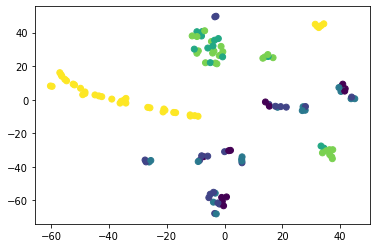

In [38]:
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=list(labels.numpy()))

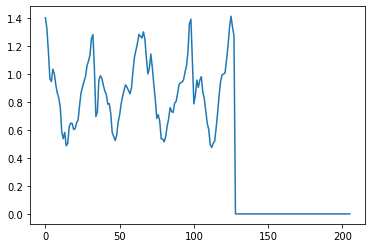

In [39]:
plt.plot(data.numpy()[60,0,:])

In [60]:
data, labels, aug1, data_f, aug1_f = next(iter(train_dl))

In [61]:
data.shape

torch.Size([128, 1, 500])